In [1]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [2]:
def get_data_ch7():
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) /data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), torch.tensor(data[:1500, -1], dtype=torch.float32)

In [4]:
features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

In [13]:
def sgd(params, states, hyperparams):
    for param in params:
        param.data -= hyperparams['lr'] * param.grad.data

In [14]:
def train_ch7(optimzer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    
    ls = [eval_loss()]
    
    data_set = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(data_set, batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            l.backward()
            optimzer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size %100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.245208, 0.014621 sec per epoch


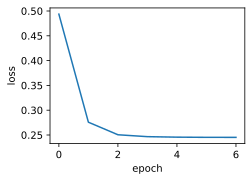

In [15]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.243399, 0.525853 sec per epoch


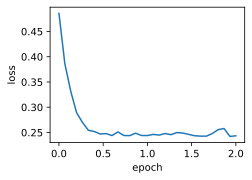

In [16]:
train_sgd(0.005, 1)

loss: 0.245260, 0.063206 sec per epoch


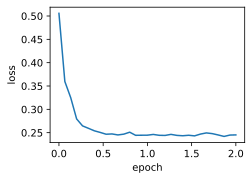

In [17]:
train_sgd(0.05, 10)

In [22]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features,
                      labels, batch_size=10, num_epochs=2):
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)
    
    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2
    
    ls = [eval_loss()]
    
    data_set = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(data_set, batch_size, shuffle=True)
    
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X).view(-1), y) / 2
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.243315, 0.057884 sec per epoch


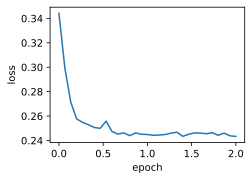

In [23]:
train_pytorch_ch7(optim.SGD, {'lr': 0.05}, features, labels, 10)